# Статистический анализ данных #

### Описание проекта ###

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

***Тариф «Смарт»***
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 
   * минута разговора: 3 рубля 
   * сообщение: 3 рубля 
   * 1 Гб интернет-трафика: 200 рублей

***Тариф «Ультра»***
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
   * минута разговора: 1 рубль
   * сообщение: 1 рубль
   * 1 Гб интернет-трафика: 150 рублей
   

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.


## Обзор данных ## 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats as st

try:
    df_users = pd.read_csv('/datasets/users.csv')
except:
    df_users = pd.read_csv('users.csv')
display(df_users.head())
df_users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [2]:
print(df_users['user_id'].min())
print(df_users['user_id'].max())

1000
1499


In [3]:
display(df_users[df_users['churn_date'].isna() == False].head())
df_users[df_users['churn_date'].isna() == False].info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart


<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 19 to 498
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     38 non-null     int64 
 1   age         38 non-null     int64 
 2   churn_date  38 non-null     object
 3   city        38 non-null     object
 4   first_name  38 non-null     object
 5   last_name   38 non-null     object
 6   reg_date    38 non-null     object
 7   tariff      38 non-null     object
dtypes: int64(2), object(6)
memory usage: 2.7+ KB


In [4]:
try:
    df_calls = pd.read_csv('/datasets/calls.csv')
except:
    df_calls = pd.read_csv('calls.csv')
display(df_calls.head())
df_calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
try:
    df_messages = pd.read_csv('/datasets/messages.csv')
except:
    df_messages = pd.read_csv('messages.csv')
display(df_messages.head())
df_messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [6]:
try:
    df_internet = pd.read_csv('/datasets/internet.csv')
except:
    df_internet = pd.read_csv('internet.csv')
display(df_internet.head())
df_internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [7]:
print(len(df_internet['Unnamed: 0'].unique()))
df_internet['Unnamed: 0'].unique()

149396


array([     0,      1,      2, ..., 149393, 149394, 149395], dtype=int64)

In [8]:
try:
    df_tariffs = pd.read_csv('/datasets/tariffs.csv')
except:
    df_tariffs = pd.read_csv('tariffs.csv')
display(df_tariffs.head())
df_tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### Вывыод ###

У нас имеется 5 датафреймов, содержащие данные о тарифах, пользователях, их звонках, сообщениях и использовании интернета.

Пропуски значений есть только в данных о пользователях `df_users` в столбце `churn_date` — дата прекращения пользования тарифом. Соответсвенно, если значение пропущено, то тариф ещё действовал на момент выгрузки данных. 

Во всех датафреймах, кроме `df_tariffs` есть столбцы, содержащие дату. Однако данные в них представлены типом `object`, а не `datetime`. Это нужно исправить.

Также данные в столбцах `user_id` имеют тип `int`, т.к. представлены числами от 1000 до 1499. Но так как эти данные - категориальные, а не количественные, лучше заменить из на тип `str`.

Кроме того, в `df_internet` присутсвует столбец `Unnamed: 0`, в котором содержатся численные значения от 0 до 149395 по порядку. Судя по всему, по данному столбцу должна идти индексация строк, так как его значения полностью совпадают с индексами.

## Предобработка данных ##

### Изменение типов данных ### 

Изменим тип даты в датафреймах на `datetime`, а также `user_id` на тип `str`.

In [9]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_calls['user_id'] = df_calls['user_id'].astype('str')

df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 6.2+ MB


In [10]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_messages['user_id'] = df_messages['user_id'].astype('str')

df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 2.8+ MB


In [11]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_internet['user_id'] = df_internet['user_id'].astype('str')

df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [12]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users['user_id'] = df_users['user_id'].astype('str')

df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    object        
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 31.4+ KB


Типы данных успешно изменены.

### Поиск и устранение ошибок ###

Как уже отмечалось выше, в `df_internet` присутсвует столбец `Unnamed: 0`, который можно удалить.

In [13]:
df_internet = df_internet.drop(columns='Unnamed: 0')
df_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [14]:
df_internet['mb_used'].value_counts()

0.00      19598
335.91        9
447.30        9
197.56        9
199.11        8
          ...  
182.69        1
726.03        1
315.12        1
898.99        1
677.66        1
Name: mb_used, Length: 70003, dtype: int64

In [15]:
null_ratio = len(df_internet.query('mb_used == 0.0')) / len(df_internet)
print(f'Процент нулевых сессий {null_ratio:.1%}')

Процент нулевых сессий 13.1%


In [16]:
df_internet.query('user_id == "1002"').sort_values(by='session_date').head(20)

,id,mb_used,session_date,user_id
324,1002_17,318.85,2018-06-17,1002
370,1002_63,706.58,2018-06-17,1002
351,1002_44,719.81,2018-06-18,1002
494,1002_187,454.39,2018-06-18,1002
434,1002_127,540.13,2018-06-19,1002
509,1002_202,573.25,2018-06-20,1002
515,1002_208,829.14,2018-06-20,1002
422,1002_115,382.55,2018-06-21,1002
597,1002_290,586.07,2018-06-22,1002
356,1002_49,652.38,2018-06-22,1002


In [17]:
print(
    'Потрачено трафика до 0.00 -',
    df_internet.query('user_id == "1002"').sort_values(by='session_date')['mb_used'].head(10).sum(), 'Мб'
)

Потрачено трафика до 0.00 - 5763.150000000001 Мб


In [18]:
df_users[df_users['user_id'] == '1002']['tariff']

2    smart
Name: tariff, dtype: object

В столбце `mb_used` присутсвуют нулевые значения. Они занимают 13.1% от всех данных. 

Предположение, что 0.00 означает, что пользователь попытался выйти в сеть, но у него закончился лимит трафика на тарифе, не подходит. Потому что это противоречит условию, что гб просто накидываются сверху, а потом выставляется счет за перерасход. И если посмотреть по датам и использованному трафику до 0.00, тоже эта теория не подтверждается.

Сказать, что человек просто не пользовался интернетом в этот день тоже нельзя, т.к. есть дни, когда юзер несколько раз выходил в сеть,  и тратил мб, и в тот же день есть сессия с 0.00.

Можно предположить, конечно, что за эту сессию были потрачены не мегабайты, а килобайты, но по сути даже 8 кб при переводе уже должны дать 0.01 мб, а не 0.00, а значит такой вариант тоже маловероятен.

Т.к. определить причину появления этих значений мы не можем, а удалять их нельзя, т.к. лишимся большого объема данных, эти данные мы оставим без изменений.

In [19]:
df_calls['duration'].value_counts()

0.00     39613
5.50       142
4.49       142
6.15       141
6.38       141
         ...  
26.32        1
24.51        1
27.24        1
29.89        1
27.43        1
Name: duration, Length: 2871, dtype: int64

В данном случае, звонки с длительностью 0.00 - это пропущенные звонки, и это не является ошибкой.

Так как «Мегалайн» всегда округляет секунды до минут, и округляется каждый звонок, то для удобства дальнейших расчетов добавим столбец, в котором будут содержатся округленные значения минут.

In [20]:
df_calls['full_minutes'] = np.ceil(df_calls['duration'])
df_calls.head(5)

,id,call_date,duration,user_id,full_minutes
0,1000_0,2018-07-25,0.00,1000,0.0
1,1000_1,2018-08-17,0.00,1000,0.0
2,1000_2,2018-06-11,2.85,1000,3.0
3,1000_3,2018-09-21,13.80,1000,14.0
4,1000_4,2018-12-15,5.18,1000,6.0


Теперь поищем ошибки в данных о пользователях.

In [21]:
df_users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

Необычных или выбивающихся значений в возрасте нет.

In [22]:
df_users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [23]:
np.sort(df_users['city'].unique())

array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

In [24]:
df_users['reg_date'].describe()

C:\Users\funkyabe\AppData\Local\Temp\ipykernel_16272\656204730.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_users['reg_date'].describe()


count                     500
unique                    270
top       2018-05-28 00:00:00
freq                        8
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: reg_date, dtype: object

In [25]:
df_users['churn_date'].describe()

C:\Users\funkyabe\AppData\Local\Temp\ipykernel_16272\1782184359.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_users['churn_date'].describe()


count                      38
unique                     33
top       2018-10-03 00:00:00
freq                        2
first     2018-08-17 00:00:00
last      2018-12-30 00:00:00
Name: churn_date, dtype: object

В тарифах и городах ошибок также нет. В датах регистрации и отключения тарифа тоже нет выбивающихся значений - все даты в пределах 2018 года.

Искать необычные значения в именах и фамилиях нет смысла, т.к.они бывают довольно уникальными.

В таблице с данными о тарифах столбец с названиями тарифов имеет название `tariff_name`, тогда как в остальных таблица он называется просто `tariff`. Для дальнейшего удобства переименуем его.

In [26]:
df_tariffs = df_tariffs.rename(columns={'tariff_name':'tariff'})

### Подготовка пользовательских данных ### 

Для каждого пользователя нужно рассчитать следующие параметры:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Для начала в каждую таблицу добавим столбец с месяцем.

In [27]:
df_calls['month'] = df_calls['call_date'].dt.month
df_calls.head()

,id,call_date,duration,user_id,full_minutes,month
0,1000_0,2018-07-25,0.00,1000,0.0,7
1,1000_1,2018-08-17,0.00,1000,0.0,8
2,1000_2,2018-06-11,2.85,1000,3.0,6
3,1000_3,2018-09-21,13.80,1000,14.0,9
4,1000_4,2018-12-15,5.18,1000,6.0,12


In [28]:
df_messages['month'] = df_messages['message_date'].dt.month
df_messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [29]:
df_internet['month'] = df_internet['session_date'].dt.month
df_internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


Теперь для каждой таблицы найдем сколько было потрачено минут / смс / гб из тарифа, а так же сколько было потрачено сверх тарифа и сколько это стоит.

In [30]:
calls_made = df_calls.groupby(by=['user_id', 'month']).count().reset_index()

calls_made.head()

,user_id,month,id,call_date,duration,full_minutes
0,1000,5,22,22,22,22
1,1000,6,43,43,43,43
2,1000,7,47,47,47,47
3,1000,8,52,52,52,52
4,1000,9,58,58,58,58


In [31]:
calls_by_months = df_calls.groupby(by=['user_id', 'month']).sum().reset_index()

calls_by_months['calls_made'] = calls_made['id']

calls_by_months = (
    calls_by_months
    .merge(df_users[['user_id', 'tariff', 'city']], on='user_id', how='left')
    .merge(df_tariffs[['tariff', 'minutes_included', 'rub_per_minute']], on='tariff', how='left')
)

calls_by_months

,user_id,month,duration,full_minutes,calls_made,tariff,city,minutes_included,rub_per_minute
0,1000,5,150.06,159.0,22,ultra,Краснодар,3000,1
1,1000,6,158.90,172.0,43,ultra,Краснодар,3000,1
2,1000,7,318.80,340.0,47,ultra,Краснодар,3000,1
3,1000,8,389.87,408.0,52,ultra,Краснодар,3000,1
4,1000,9,440.14,466.0,58,ultra,Краснодар,3000,1
...,...,...,...,...,...,...,...,...,...
3169,1498,10,232.63,247.0,41,smart,Владикавказ,500,3
3170,1499,9,64.65,70.0,9,smart,Пермь,500,3
3171,1499,10,429.91,449.0,68,smart,Пермь,500,3
3172,1499,11,576.50,612.0,74,smart,Пермь,500,3


In [32]:
calls_by_months['minutes_overrun'] = np.maximum(calls_by_months['full_minutes'] - calls_by_months['minutes_included'], 0)
calls_by_months.tail()

,user_id,month,duration,full_minutes,calls_made,tariff,city,minutes_included,rub_per_minute,minutes_overrun
3169,1498,10,232.63,247.0,41,smart,Владикавказ,500,3,0.0
3170,1499,9,64.65,70.0,9,smart,Пермь,500,3,0.0
3171,1499,10,429.91,449.0,68,smart,Пермь,500,3,0.0
3172,1499,11,576.50,612.0,74,smart,Пермь,500,3,112.0
3173,1499,12,465.16,492.0,69,smart,Пермь,500,3,0.0


In [33]:
calls_by_months['minutes_overrun'] = calls_by_months['minutes_overrun'].where(calls_by_months['minutes_overrun'] > 0)
calls_by_months['minutes_overpay'] = calls_by_months['minutes_overrun'] * calls_by_months['rub_per_minute']

calls_by_months

,user_id,month,duration,full_minutes,calls_made,tariff,city,minutes_included,rub_per_minute,minutes_overrun,minutes_overpay
0,1000,5,150.06,159.0,22,ultra,Краснодар,3000,1,NaN,NaN
1,1000,6,158.90,172.0,43,ultra,Краснодар,3000,1,NaN,NaN
2,1000,7,318.80,340.0,47,ultra,Краснодар,3000,1,NaN,NaN
3,1000,8,389.87,408.0,52,ultra,Краснодар,3000,1,NaN,NaN
4,1000,9,440.14,466.0,58,ultra,Краснодар,3000,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3169,1498,10,232.63,247.0,41,smart,Владикавказ,500,3,NaN,NaN
3170,1499,9,64.65,70.0,9,smart,Пермь,500,3,NaN,NaN
3171,1499,10,429.91,449.0,68,smart,Пермь,500,3,NaN,NaN
3172,1499,11,576.50,612.0,74,smart,Пермь,500,3,112.0,336.0


In [34]:
sms_by_months = (
    df_messages
    .groupby(by=['user_id', 'month']).count().reset_index()
    .merge(df_users[['user_id', 'tariff', 'city']], on='user_id', how='left')
    .merge(df_tariffs[['tariff', 'messages_included', 'rub_per_message']], on='tariff', how='left')
    .rename(columns={'id':'sms_used'})
    .drop(columns='message_date')
)

sms_by_months['sms_overrun'] = np.maximum(sms_by_months['sms_used'] - sms_by_months['messages_included'], 0)
sms_by_months['sms_overpay'] = sms_by_months['sms_overrun'] * sms_by_months['rub_per_message']

sms_by_months

,user_id,month,sms_used,tariff,city,messages_included,rub_per_message,sms_overrun,sms_overpay
0,1000,5,22,ultra,Краснодар,1000,1,0,0
1,1000,6,60,ultra,Краснодар,1000,1,0,0
2,1000,7,75,ultra,Краснодар,1000,1,0,0
3,1000,8,81,ultra,Краснодар,1000,1,0,0
4,1000,9,57,ultra,Краснодар,1000,1,0,0
...,...,...,...,...,...,...,...,...,...
2712,1498,10,42,smart,Владикавказ,50,3,0,0
2713,1499,9,11,smart,Пермь,50,3,0,0
2714,1499,10,48,smart,Пермь,50,3,0,0
2715,1499,11,59,smart,Пермь,50,3,9,27


In [35]:
web_by_months = (
    df_internet
    .groupby(by=['user_id', 'month']).sum().reset_index()
    .merge(df_users[['user_id', 'tariff', 'city']], on='user_id', how='left')
    .merge(df_tariffs[['tariff', 'mb_per_month_included', 'rub_per_gb']], on='tariff', how='left')
)

web_by_months['gb_used'] = np.ceil(web_by_months['mb_used'] / 1024)
web_by_months['mb_overrun'] = np.maximum(web_by_months['mb_used'] - web_by_months['mb_per_month_included'], 0)
web_by_months['gb_overrun'] = np.ceil(web_by_months['mb_overrun'] / 1024)
web_by_months['gb_overpay'] = web_by_months['gb_overrun'] * web_by_months['rub_per_gb'] 

web_by_months

,user_id,month,mb_used,tariff,city,mb_per_month_included,rub_per_gb,gb_used,mb_overrun,gb_overrun,gb_overpay
0,1000,5,2253.49,ultra,Краснодар,30720,150,3.0,0.00,0.0,0.0
1,1000,6,23233.77,ultra,Краснодар,30720,150,23.0,0.00,0.0,0.0
2,1000,7,14003.64,ultra,Краснодар,30720,150,14.0,0.00,0.0,0.0
3,1000,8,14055.93,ultra,Краснодар,30720,150,14.0,0.00,0.0,0.0
4,1000,9,14568.91,ultra,Краснодар,30720,150,15.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3198,1498,10,20579.36,smart,Владикавказ,15360,200,21.0,5219.36,6.0,1200.0
3199,1499,9,1845.75,smart,Пермь,15360,200,2.0,0.00,0.0,0.0
3200,1499,10,17788.51,smart,Пермь,15360,200,18.0,2428.51,3.0,600.0
3201,1499,11,17963.31,smart,Пермь,15360,200,18.0,2603.31,3.0,600.0


Теперь, когда мы рассчитали все доп. траты, можно найти траты каждого клиента по месяцам. Для этого вынесем необходимые данные из расчетов и добавим стоимость тарифа.

In [36]:
monthly_pays = (
    calls_by_months
    .merge(web_by_months[['user_id', 'month', 'tariff', 'city', 'gb_used', 'gb_overrun', 'gb_overpay']], on=['user_id', 'month', 'tariff', 'city'], how='outer')
    .merge(sms_by_months[['user_id', 'month', 'tariff', 'city', 'sms_used', 'sms_overrun', 'sms_overpay']], on=['user_id', 'month', 'tariff', 'city'], how='outer')
    .merge(df_tariffs[['tariff', 'rub_monthly_fee']], on='tariff', how='left')
    .drop(columns=['duration', 'minutes_included', 'rub_per_minute'])
    .fillna(0)    
)

monthly_pays['total_pay'] = (
    monthly_pays['rub_monthly_fee'] 
    + monthly_pays['minutes_overpay']
    + monthly_pays['gb_overpay']
    + monthly_pays['sms_overpay']
)

monthly_pays

,user_id,month,full_minutes,calls_made,tariff,city,minutes_overrun,minutes_overpay,gb_used,gb_overrun,gb_overpay,sms_used,sms_overrun,sms_overpay,rub_monthly_fee,total_pay
0,1000,5,159.0,22.0,ultra,Краснодар,0.0,0.0,3.0,0.0,0.0,22.0,0.0,0.0,1950,1950.0
1,1000,6,172.0,43.0,ultra,Краснодар,0.0,0.0,23.0,0.0,0.0,60.0,0.0,0.0,1950,1950.0
2,1000,7,340.0,47.0,ultra,Краснодар,0.0,0.0,14.0,0.0,0.0,75.0,0.0,0.0,1950,1950.0
3,1000,8,408.0,52.0,ultra,Краснодар,0.0,0.0,14.0,0.0,0.0,81.0,0.0,0.0,1950,1950.0
4,1000,9,466.0,58.0,ultra,Краснодар,0.0,0.0,15.0,0.0,0.0,57.0,0.0,0.0,1950,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,0.0,smart,Санкт-Петербург,0.0,0.0,11.0,0.0,0.0,17.0,0.0,0.0,550,550.0
3210,1489,9,0.0,0.0,smart,Санкт-Петербург,0.0,0.0,17.0,2.0,400.0,32.0,0.0,0.0,550,950.0
3211,1489,10,0.0,0.0,smart,Санкт-Петербург,0.0,0.0,20.0,5.0,1000.0,21.0,0.0,0.0,550,1550.0
3212,1489,11,0.0,0.0,smart,Санкт-Петербург,0.0,0.0,18.0,3.0,600.0,20.0,0.0,0.0,550,1150.0


In [37]:
total_by_month = monthly_pays.pivot_table(index='user_id', columns='month', values='total_pay', fill_value=0)
display(total_by_month)
total_by_month.info()

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
1001,0,0,0,0,0,0,0,0,0,0,1150,550
1002,0,0,0,0,0,550,1150,1550,950,550,1350,1150
1003,0,0,0,0,0,0,0,1950,1950,1950,1950,1950
1004,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,1950,2400,1950,3300,1950
1496,550,3432,2721,1813,2350,1715,2596,2231,2950,3150,3036,1807
1497,0,0,0,0,0,0,0,0,0,550,550,1685


<class 'pandas.core.frame.DataFrame'>
Index: 498 entries, 1000 to 1499
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1       498 non-null    int64
 1   2       498 non-null    int64
 2   3       498 non-null    int64
 3   4       498 non-null    int64
 4   5       498 non-null    int64
 5   6       498 non-null    int64
 6   7       498 non-null    int64
 7   8       498 non-null    int64
 8   9       498 non-null    int64
 9   10      498 non-null    int64
 10  11      498 non-null    int64
 11  12      498 non-null    int64
dtypes: int64(12)
memory usage: 50.6+ KB


После обработки всех данных видим, что у нас потерялись 2 пользователя. Найдем их и выясним, почему.

In [38]:
lost_users = []

for value in df_users['user_id']:
    if value not in monthly_pays['user_id'].unique():
        lost_users.append(value)

df_users.query('user_id.isin(@lost_users)')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


In [39]:
display(df_calls.query('user_id.isin(@lost_users)'))
display(df_messages.query('user_id.isin(@lost_users)'))
display(df_internet.query('user_id.isin(@lost_users)'))

,id,call_date,duration,user_id,full_minutes,month


,id,message_date,user_id,month


,id,mb_used,session_date,user_id,month


Видим, что оба пользователя были подключены меньше недели и за это время не пользовались услугами оператора, поэтому они и не попали в итоговую таблицу.

## Анализ и описание данных ##

Нужно проанализировать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

Для этого нужно посчитать среднее количество, дисперсию и стандартное отклонение, построить гистограммы и описать распределения.

In [40]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Смарт
        full_minutes  minutes_overrun  minutes_overpay
count   2229.000000      2229.000000      2229.000000
mean     417.934948        41.605653       124.816958
std      190.313730        84.678573       254.035718
min        0.000000         0.000000         0.000000
25%      282.000000         0.000000         0.000000
50%      422.000000         0.000000         0.000000
75%      545.000000        45.000000       135.000000
max     1435.000000       935.000000      2805.000000

Ультра
        full_minutes  minutes_overrun  minutes_overpay
count    985.000000            985.0            985.0
mean     526.623350              0.0              0.0
std      317.606098              0.0              0.0
min        0.000000              0.0              0.0
25%      284.000000              0.0              0.0
50%      518.000000              0.0              0.0
75%      752.000000              0.0              0.0
max     1673.000000              0.0              0.0


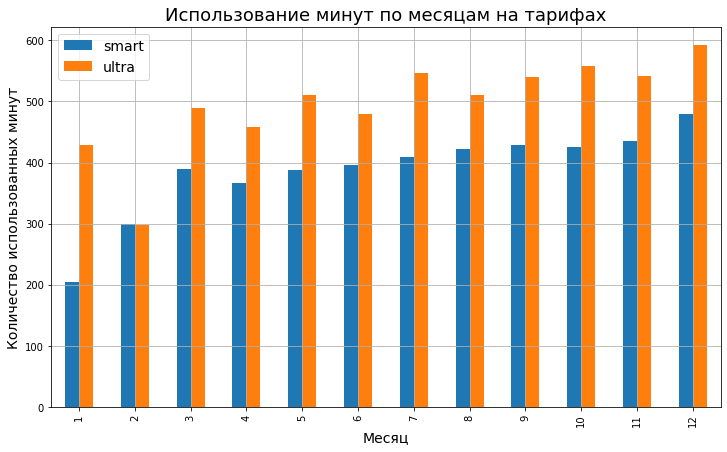

In [41]:
fig, ax = plt.subplots(figsize=(12,7))

monthly_pays.pivot_table(index='month', columns='tariff', values='full_minutes', aggfunc='mean').plot.bar(ax=ax)
ax.set_xlabel('Месяц', fontsize=14)
ax.set_ylabel('Количество использованных минут', fontsize=14)
ax.set_title('Использование минут по месяцам на тарифах', fontsize=18)
ax.legend(fontsize=14)
ax.grid(True)


print('Смарт\n', monthly_pays.query('tariff=="smart"')[['full_minutes', 'minutes_overrun', 'minutes_overpay']].describe())
print()
print('Ультра\n', monthly_pays.query('tariff=="ultra"')[['full_minutes', 'minutes_overrun', 'minutes_overpay']].describe())

<AxesSubplot:>

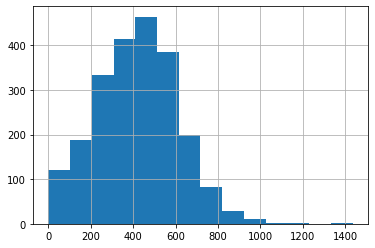

In [42]:
monthly_pays.query('tariff=="smart"')['full_minutes'].hist(bins=14)

<AxesSubplot:>

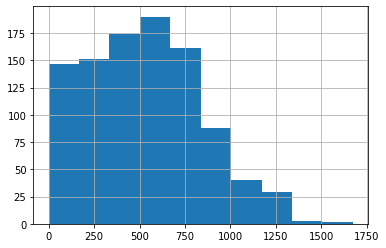

In [43]:
monthly_pays.query('tariff=="ultra"')['full_minutes'].hist()

График показывает, что в среднем в месяц пользователям и того, и другого тарифа хватает количества минут, включенных в тариф.
Кроме того, видно, что пользователи тарифа "Ультра" в среднем тратят больше минут в месяц.

Это подтверждают и гистограммы. 
Кроме того, по гистограммам видно, пользователям "Ультра" в большинстве случаев хватает 1000 минут в месяц. Больше 1700 минут за год не проговорил никто. А так же довольно большой объем тех, кто использует менее 300 минут в месяц.

Большая часть пользователей "Смарт" укладывается в лимит в 500 минут, однако, многим этого бывает недостаточно, и они тратят по 600-700 минут в месяц.

In [44]:
print('Дисперсия по звонкам тарифа Смарт -', np.var(monthly_pays.query('tariff=="smart"')['full_minutes']))
print('Дисперсия по звонкам тарифа Ультра -', np.var(monthly_pays.query('tariff=="ultra"')['full_minutes']))

Дисперсия по звонкам тарифа Смарт - 36203.06665209469
Дисперсия по звонкам тарифа Ультра - 100771.2236172022


Дисперсия у тарифа Ультра более чем в 2 раза выше, чем у тарифа Смарт.
Это значит, что поведение пользователей внутри тарифа сильно различается: кто-то использует 200 минут в месяц, а кто-то 1500.
Для тарифа Смарт разброс меньше.

Смарт
           sms_used  sms_overrun  sms_overpay
count  2229.000000  2229.000000  2229.000000
mean     33.384029     5.799910    17.399731
std      28.227876    13.442456    40.327368
min       0.000000     0.000000     0.000000
25%      10.000000     0.000000     0.000000
50%      28.000000     0.000000     0.000000
75%      51.000000     1.000000     3.000000
max     143.000000    93.000000   279.000000

Ультра
          sms_used  sms_overrun  sms_overpay
count  985.000000        985.0        985.0
mean    49.363452          0.0          0.0
std     47.804457          0.0          0.0
min      0.000000          0.0          0.0
25%      6.000000          0.0          0.0
50%     38.000000          0.0          0.0
75%     79.000000          0.0          0.0
max    224.000000          0.0          0.0


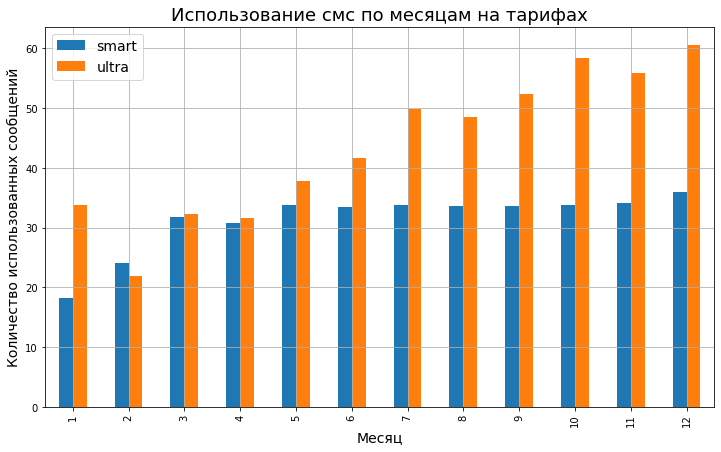

In [45]:
fig, ax = plt.subplots(figsize=(12,7))

monthly_pays.pivot_table(index='month', columns='tariff', values='sms_used', aggfunc='mean').plot.bar(ax=ax)
ax.set_xlabel('Месяц', fontsize=14)
ax.set_ylabel('Количество использованных сообщений', fontsize=14)
ax.set_title('Использование смс по месяцам на тарифах', fontsize=18)
ax.legend(fontsize=14)
ax.grid(True)


print('Смарт\n', monthly_pays.query('tariff=="smart"')[['sms_used', 'sms_overrun', 'sms_overpay']].describe())
print()
print('Ультра\n', monthly_pays.query('tariff=="ultra"')[['sms_used', 'sms_overrun', 'sms_overpay']].describe())

<AxesSubplot:>

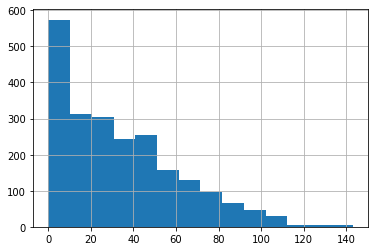

In [46]:
monthly_pays.query('tariff=="smart"')['sms_used'].hist(bins=14)

<AxesSubplot:>

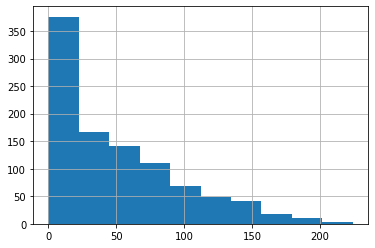

In [47]:
monthly_pays.query('tariff=="ultra"')['sms_used'].hist()

In [48]:
print('Дисперсия по сообщениям тарифа Смарт -', np.var(monthly_pays.query('tariff=="smart"')['sms_used']))
print('Дисперсия по сообщениям тарифа Ультра -', np.var(monthly_pays.query('tariff=="ultra"')['sms_used']))

Дисперсия по сообщениям тарифа Смарт - 796.455482917076
Дисперсия по сообщениям тарифа Ультра - 2282.946075394882


С сообщениями ситуация такая же, как и со звонками: пользователям обоих тарифов, в среднем, хватает доступных сообщений в месяц, но пользователи "Смарт" периодически выходят за рамки тарифа.
Пользователи "Ультра" наоборот не используют доступное им количество сообщений наполную.

Дисперсия так же выше у пользователей тарифа Ультра.

Смарт
            gb_used   gb_overrun   gb_overpay
count  2229.000000  2229.000000  2229.000000
mean     16.328847     2.988784   597.756842
std       5.747061     3.682820   736.563904
min       0.000000     0.000000     0.000000
25%      13.000000     0.000000     0.000000
50%      17.000000     2.000000   400.000000
75%      20.000000     5.000000  1000.000000
max      38.000000    23.000000  4600.000000

Ультра
           gb_used  gb_overrun   gb_overpay
count  985.000000  985.000000   985.000000
mean    19.494416    0.801015   120.152284
std      9.853511    2.507914   376.187114
min      0.000000    0.000000     0.000000
25%     12.000000    0.000000     0.000000
50%     19.000000    0.000000     0.000000
75%     27.000000    0.000000     0.000000
max     49.000000   19.000000  2850.000000


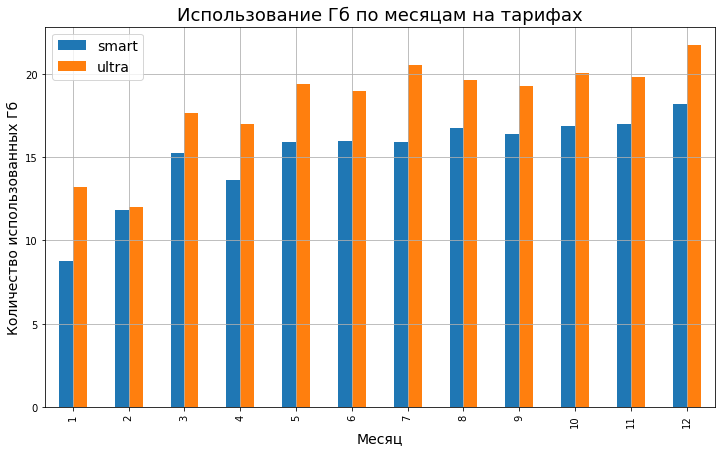

In [49]:
fig, ax = plt.subplots(figsize=(12,7))

monthly_pays.pivot_table(index='month', columns='tariff', values='gb_used', aggfunc='mean').plot.bar(ax=ax)
ax.set_xlabel('Месяц', fontsize=14)
ax.set_ylabel('Количество использованных Гб', fontsize=14)
ax.set_title('Использование Гб по месяцам на тарифах', fontsize=18)
ax.legend(fontsize=14)
ax.grid(True)

print('Смарт\n', monthly_pays.query('tariff=="smart"')[['gb_used','gb_overrun', 'gb_overpay']].describe())
print()
print('Ультра\n', monthly_pays.query('tariff=="ultra"')[['gb_used','gb_overrun', 'gb_overpay']].describe())

<AxesSubplot:>

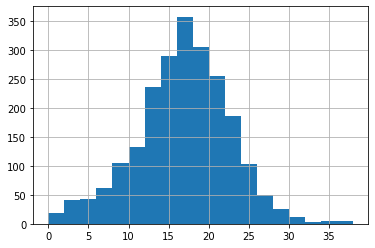

In [50]:
monthly_pays.query('tariff=="smart"')['gb_used'].hist(bins=19)

<AxesSubplot:>

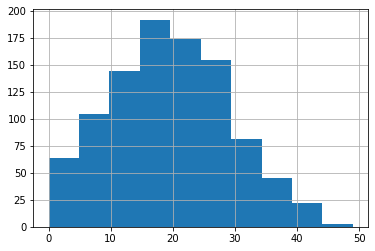

In [51]:
monthly_pays.query('tariff=="ultra"')['gb_used'].hist()

In [52]:
print('Дисперсия по интернет-трафику тарифа Смарт -', np.var(monthly_pays.query('tariff=="smart"')['gb_used']))
print('Дисперсия по интернет-трафику тарифа Ультра -', np.var(monthly_pays.query('tariff=="ultra"')['gb_used']))

Дисперсия по интернет-трафику тарифа Смарт - 33.013887454837445
Дисперсия по интернет-трафику тарифа Ультра - 96.99311602978692


С интернет-трафиком дело обстоит несколько иначе: пользователи "Ультра" все еще используют, в среднем, больше трафика, однако, видно, что пользователям "Смарт" не хватает Гб, входящих в тариф - в среднем они тратят около 16 Гб, а многие тратят до 25 гб, тогда как в пакет входит всего 15.
Пользователи "Ультра" также иногда испытывают нехватку трафика - впервые есть значения, выходящие за лимит.

Смарт
 count    2229.000000
mean     1289.973531
std       818.404367
min       550.000000
25%       550.000000
50%      1023.000000
75%      1750.000000
max      6770.000000
Name: total_pay, dtype: float64

Ультра
 count     985.000000
mean     2070.152284
std       376.187114
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: total_pay, dtype: float64


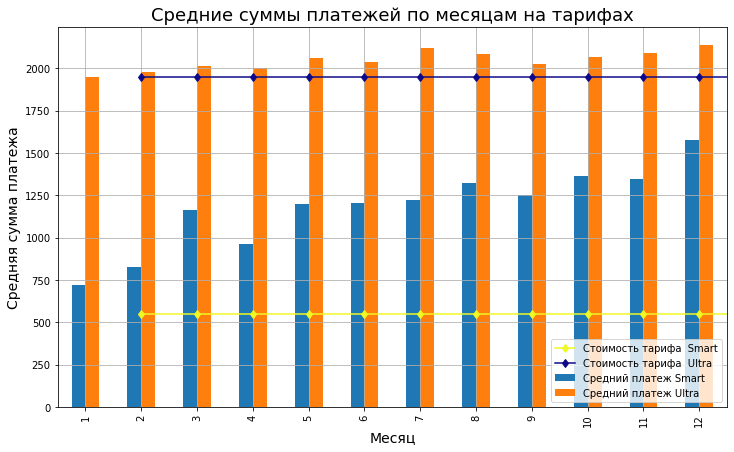

In [53]:
fig, ax = plt.subplots(figsize=(15,10))

(monthly_pays
 .pivot_table(index='month', columns='tariff', values='rub_monthly_fee')
 .rename(columns={'smart':'Стоимость тарифа  Smart', 'ultra':'Стоимость тарифа  Ultra'})
 .plot(kind='line', marker='d', colormap='plasma_r', ax=ax))

(monthly_pays
 .pivot_table(index='month', columns='tariff', values='total_pay', aggfunc='mean')
 .rename(columns={'smart':'Средний платеж Smart', 'ultra':'Средний платеж Ultra'})
 .plot(kind='bar', ax=ax, figsize=(12,7), grid=True))

ax.set_xlabel('Месяц', fontsize=14)
ax.set_ylabel('Средняя сумма платежа', fontsize=14)
ax.set_title('Средние суммы платежей по месяцам на тарифах', fontsize=18)
ax.legend(fontsize=10, loc=4)
ax.grid(True)


print('Смарт\n', monthly_pays.query('tariff=="smart"')['total_pay'].describe())
print()
print('Ультра\n', monthly_pays.query('tariff=="ultra"')['total_pay'].describe())

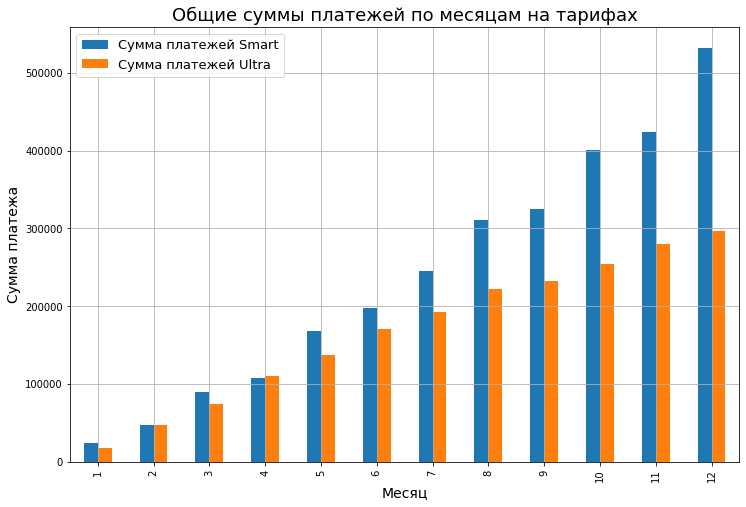

In [54]:
fig, ax = plt.subplots(figsize=(12,8))

(monthly_pays
 .pivot_table(index='month', columns='tariff', values='total_pay', aggfunc='sum')
 .rename(columns={'smart':'Сумма платежей Smart', 'ultra':'Сумма платежей Ultra'})
 .plot.bar(ax=ax))
 
ax.set_xlabel('Месяц', fontsize=14)
ax.set_ylabel('Сумма платежа', fontsize=14)
ax.set_title('Общие суммы платежей по месяцам на тарифах', fontsize=18)
ax.legend(fontsize=13, loc=2)
ax.grid(True)

2418.534874082868


<AxesSubplot:>

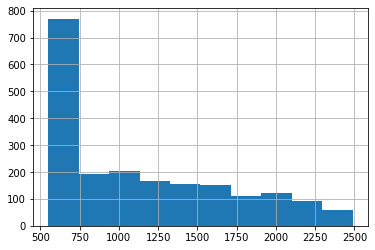

In [55]:
print(
    monthly_pays.query('tariff=="smart"')['total_pay'].mean() + 3 * np.std(monthly_pays.query('tariff=="ultra"')['total_pay'], ddof=1)
)

monthly_pays.query('tariff=="smart" and total_pay < 2500')['total_pay'].hist()

3198.713627615558


<AxesSubplot:>

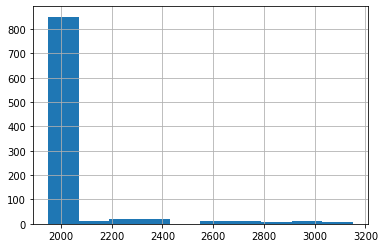

In [56]:
print(
    monthly_pays.query('tariff=="ultra"')['total_pay'].mean() + 3 * np.std(monthly_pays.query('tariff=="ultra"')['total_pay'], ddof=1)
)

monthly_pays.query('tariff=="ultra" and total_pay < 3200')['total_pay'].hist()

In [57]:
print('Дисперсия по платежам тарифа Смарт -', np.var(monthly_pays.query('tariff=="smart"')['total_pay']))
print('Дисперсия по платежам тарифа Ультра -', np.var(monthly_pays.query('tariff=="ultra"')['total_pay']))

Дисперсия по платежам тарифа Смарт - 669485.2209234245
Дисперсия по платежам тарифа Ультра - 141373.07325620347


По оплате тарифов и доп.услуг видно, что, несмотря на то, что в среднем за "Смарт" платят все еще меньше, данные пользователи переплачивают за свой тариф, часто более чем в 2 раза, в то время, как "Ультра" в большинстве случаев платят только абонентскую плату. 
Дисперсия по тарифу Ультра в данном случае в разы меньше, что означает, что эти пользователи гораздо чаще платят стабильно, одну и ту же сумму.


## Проверка гипотез ## 

Итак, у нас есть 2 гипотезы, которые нужно проверить:

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Средняя выручка пользователей двух тарифов различаются ###

Для проверки гипотезы воспользуемся t-тестом. 
За нулевую гипотезу примем, что выручка пользователей тарифов "Ультра" и "Смарт" не различается. Соответсвенно, альтернативная гипотеза - выручки различаются.

Так как стандартные отклонения выборок, а соответственно и дисперсии, сильно отличаются (`std` == 818.404367 у "Смарт" против 376.187114 у "Ультра"), то нужно задать параметр `equal_var` равный `False`.
Уровень значимости примем 1%

In [58]:
smart_pays = monthly_pays.query('tariff=="smart"')['total_pay']
ultra_pays = monthly_pays.query('tariff=="ultra"')['total_pay']

results = st.ttest_ind(
    smart_pays, 
    ultra_pays,
    equal_var=False
)

alpha = .01 

print('p-значение:', results.pvalue) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу. Выручки у тарифов различаются.")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу. Выручки у тарифов различаются.


Гипотеза о том, что выручка пользователей тарифов «Ультра» и «Смарт» одинкова не подтвердилась. Соответсвенно, выручка различается.

Сравним, какой тариф приносит больше дохода в год.

In [59]:
print('Суммарная выручка тарифа Ультра', monthly_pays.query('tariff=="ultra"')['total_pay'].sum())
print('Суммарная выручка тарифа Смарт', monthly_pays.query('tariff=="smart"')['total_pay'].sum())
print()
print(monthly_pays.query('tariff=="ultra"')['total_pay'].sum() < monthly_pays.query('tariff=="smart"')['total_pay'].sum())
print()
print('Средний месячный платеж тарифа Ультра', monthly_pays.query('tariff=="ultra"')['total_pay'].mean())
print('Средний месячный платеж тарифа Смарт', monthly_pays.query('tariff=="smart"')['total_pay'].mean())
print()
print(monthly_pays.query('tariff=="ultra"')['total_pay'].mean() < monthly_pays.query('tariff=="smart"')['total_pay'].mean())

Суммарная выручка тарифа Ультра 2039100.0
Суммарная выручка тарифа Смарт 2875351.0

True

Средний месячный платеж тарифа Ультра 2070.1522842639592
Средний месячный платеж тарифа Смарт 1289.9735307312696

False


За счет большего количества пользователей и постоянных переплат тариф "Смарт" в общем приносит большую выручку, чем "Ультра".


### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов ###

За нулевую гипотезу так же принимаем, что выручка у пользователей из Москвы такая же, как и всех остальных регионов. 

In [60]:
moscow_pays = monthly_pays.query('city=="Москва"')['total_pay']
other_cities_pays = monthly_pays.query('city!="Москва"')['total_pay']

results = st.ttest_ind(
    moscow_pays, 
    other_cities_pays,
    equal_var=False
)

alpha = .01 

print('p-значение:', results.pvalue) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу. Выручка пользователей из Москвы отличается от других регионов")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


In [61]:
print('Средняя выручка по Москве', moscow_pays.mean())
print('Средняя выручка по другим регионам', other_cities_pays.mean())

Средняя выручка по Москве 1546.7135842880523
Средняя выручка по другим регионам 1524.9362274298885


Отвергнуть нулевую гипотезу не получилось - в среднем, выручка пользователей из Москвы не отличается от других регионов.

## Вывод ##

В ходе проекта мы проанализировали данные о 500 пользователях мобильной сети "Мегалайн". Для анализа были доступны 5 датафреймов, содержащие данные о пользователях, их звонках, сообщениях и использовании интернета, а также данные о 2 тарифах - "Смарт" и "Ультра".

В ходе обзора данных были обнаружены пропуски значений в данных о пользователях churn_date — дата прекращения пользования тарифом. 
Данные пропуски означали, что клиент еще использовал тариф на момент выгрузки данных.

В ходе предобработки данных, были изменены типы данных в столбцах, содержащих дату, с типа `object`, на `datetime`. 
Также данные в столбцах `user_id` имели `тип` int, т.к. представлены числами от 1000 до 1499. 
Но так как эти данные категориальные, а не количественные, они были заменены на строки.
В датафрейме `df_internet` был обнаружен столбец Unnamed: 0, в котором содержались численные значения от 0 до 149395 по порядку. Так как его значения полностью совпадали с индексами, данный столбец был удален.

После этого все данные были сведены в 1 таблицу, содержащую информацию о том, сколько минут, сообщений и Гб интернет-трафика каждый пользователь использовал в каждый месяц. 
Допольнительно было рассчитано, сколько клиент использует услуг сверх тарифных лимитов и сколько эти превышения стоят.
Кроме того, было посчитано, сколько в общем пользователь заплатил компании за каждый месяц.

Анализ данных показал, пользователи тарифа "Ультра" не используют в полном количестве минуты и смс, входящие в тариф, в то время как, пользователи "Смарт" иногда выходят за данные лимиты. 
15 Гб, входящих в тариф "Смарт", пользователям чаще всего не хватает - многие пользователи тратят до 25 Гб в месяц. 
Пользователи "Ультра" чаще всего укладываются в лимит трафика.
Анализ платежей пользователей показал, что при использовании тарифа "Смарт" клиентам часто приходится доплачивать за дополнительные услуги, часто более чем в 2 раза больше стоимости тарифа. Пользователи "Ультра" чаще всего платят только абонентскую плату.

Кроме того, в проекте проверялись 2 гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Гипотеза о разности выручки у тарифов подтвердилась.
Действиетльно, за счет большего количества пользователей и постоянных дополнительных платежей тариф "Смарт" приносит компании большую годовую выручуку.

А вот гипотеза о том, что выручка по Москве отличается от выручки по другим регионам не подтвердилась - по данному параметру средняя выручка мало различается.

**Общий вывод:** Вкладывать рекламный бюджет стоит в тариф "Смарт", т.к. за счет большего количества пользователей и дополнительных платежей сверх абонентской платы этот тариф приносит большую выручку, чем тариф "Ультра"